In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

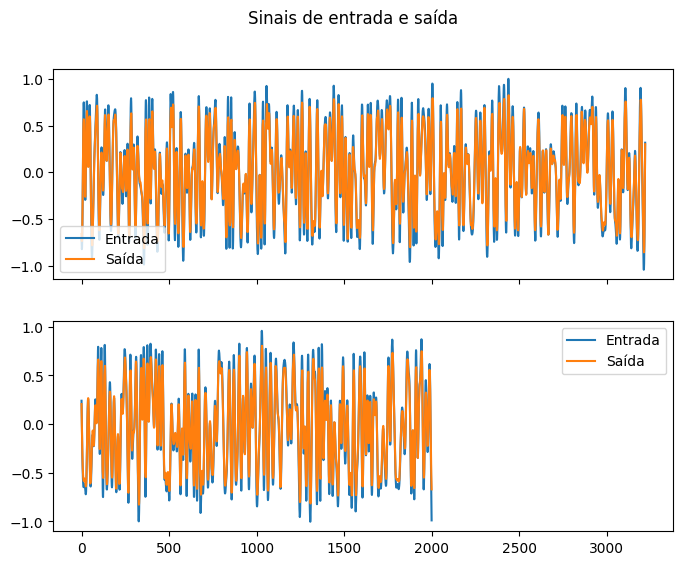

In [2]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [3]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX


def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    pot = int(2*p-2) 
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, pot):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A*C, precision)  +  readeq(-B * D, precision)
            readequated_imag = readeq(A*D , precision) +  readeq(B*C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits



In [4]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX

def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, p):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    coefficients = np.round(coefficients *(2**precision))
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A * C - B * D, precision)
            readequated_imag = readeq(A * D + B * C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits

In [5]:
P = 2
M = 1
XX_val = mp(P, M, in_data_val)
XX_ext = mp(P, M, in_data_ext)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext, out_data_ext[M:], rcond=None)
predicted_val = XX_val @ coefficients
nmse_target = 10*np.log10(np.mean(np.abs(out_data_val[M:] - predicted_val) ** 2) / np.mean(np.abs(out_data_val[M:]) ** 2))



In [6]:

XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)

nmse_values = []

for p_bits in range(2, 20):
    # print(f'{np.round(coefficients * (2 ** p_bits))}')
    in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
    out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
    in_ext_fixed = np.round(in_ext_norm * (2 ** p_bits)) 
    out_ext_fixed = np.round(out_ext_norm * (2 ** p_bits))

    XX_val = mp_int(P, M, in_val_fixed, p_bits)

    #predicted_val_fixed = XX_val @ coefficients
    predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients, XX_val, p_bits)
    nmse_fixed = 10 * np.log10(np.mean(np.abs(out_val_fixed[M:] - predicted_val_fixed) ** 2) / np.mean(np.abs(out_val_fixed[M:]) ** 2))

    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 + e_bits
    nmse_values.append((p_bits,e_bits, total_bits, nmse_fixed))

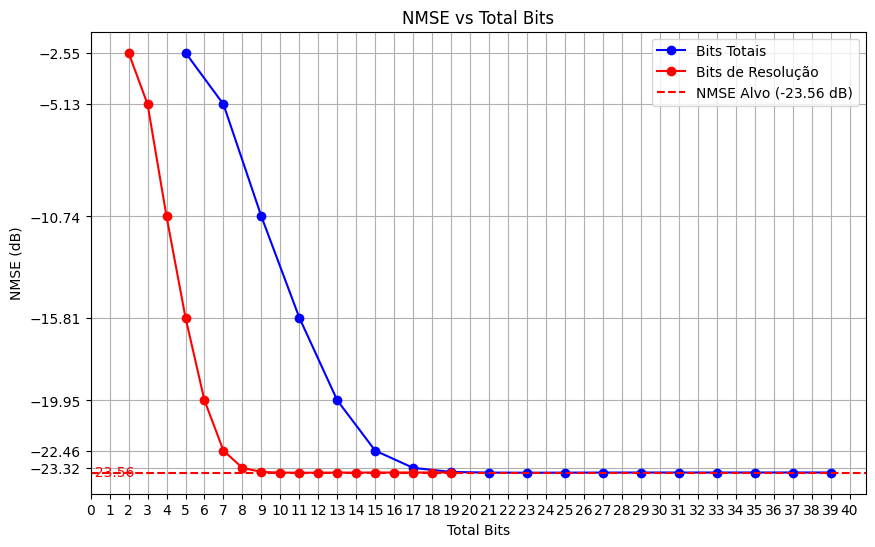

In [7]:
nmse_values = np.array(nmse_values)
total_bits_array = nmse_values[:, 2]
resol_bits_array = nmse_values[:, 0]
nmse_fixed_array = nmse_values[:, 3]

plt.figure(figsize=(10, 6))
plt.plot(total_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='b', label='Bits Totais')
plt.plot(resol_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='r', label='Bits de Resolução')

# Adicionar títulos e labels
plt.title('NMSE vs Total Bits')
plt.xlabel('Total Bits')
plt.ylabel('NMSE (dB)')
plt.xticks(np.arange(0, max(total_bits_array) + 2, 1))
plt.yticks(nmse_fixed_array[:7])

plt.axhline(y=nmse_target, color='r', linestyle='--', label=f'NMSE Alvo ({nmse_target:.4} dB)')
plt.text(0, nmse_target, f'{nmse_target:.4}', color='r', verticalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

In [8]:
bits_total = 19

bits_resol = nmse_values[nmse_values[:, 2] == bits_total, 0]
complex_numbers = coefficients * bits_resol

In [9]:
bits_resol

array([9.])

In [10]:


# Nome do arquivo VHDL de saída
output_file = "complex_constants.vhd"

# Estrutura VHDL
vhdl_header = """\
-- Arquivo gerado automaticamente por um script Python
library IEEE;
use IEEE.STD_LOGIC_1164.ALL;
use IEEE.NUMERIC_STD.ALL;

package ComplexConstants is
  constant n_bits_resolution : INTEGER := {bits_resol} + 1;
  
  subtype limited_integer is integer range 0 to 2**n_bits_resolution - 1;
  
  type complex_number is record
    real : limited_integer;
    imag : limited_integer;
  end record;

  type complex_array is array (0 to {size}) of complex_number;

  constant complex_values : complex_array := (
"""
vhdl_footer = """\
  );

end package ComplexConstants;
"""

# Função para converter um número complexo em uma string VHDL
complex_to_vhdl_string = lambda c : f"(real => {int(np.round(c.real)[0])}, imag => {int(np.round(c.imag)[0])})"

# Gerando o conteúdo VHDL
vhdl_content = vhdl_header.format(size=len(complex_numbers) - 1, bits_resol = int(bits_resol[0]))
vhdl_content += ",\n".join([f"    {complex_to_vhdl_string(c)}" for c in complex_numbers])
vhdl_content += "\n" + vhdl_footer

# Escrevendo o conteúdo no arquivo
with open(output_file, "w") as f:
    f.write(vhdl_content)

print(f"Arquivo VHDL '{output_file}' gerado com sucesso!")

Arquivo VHDL 'complex_constants.vhd' gerado com sucesso!


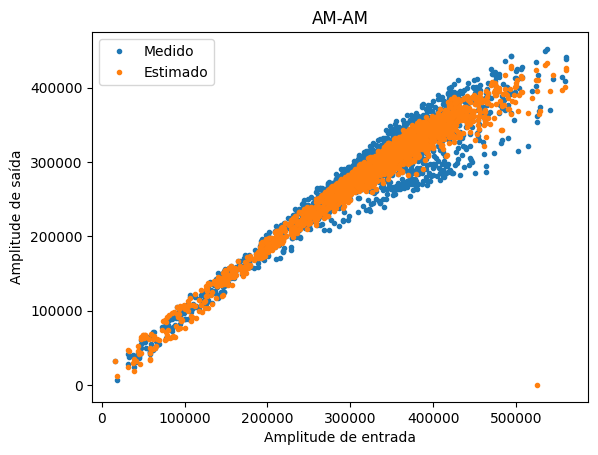

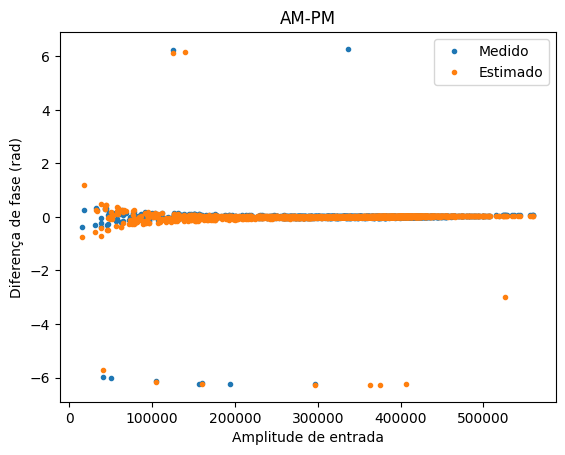

In [11]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.angle(predicted_val_fixed)-np.angle(in_val_fixed[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()